# H2O example

This notebook will give an example of how to use `skutil` preprocessors with H2OEstimators and H2OFrames.

In [2]:
from __future__ import print_function, division
import skutil
import sklearn
import h2o
import pandas as pd
import numpy as np

# we'll be plotting inline...
%matplotlib inline

print('Skutil version:  %s' % skutil.__version__)
print('H2O version:     %s' % h2o.__version__)
print('Numpy version:   %s' % np.__version__)
print('Sklearn version: %s' % sklearn.__version__)
print('Pandas version:  %s' % pd.__version__)

Skutil version:  0.0.51.working
H2O version:     3.8.2.9
Numpy version:   1.11.1
Sklearn version: 0.17.1
Pandas version:  0.18.1


### Initialize H2O

First, we'll start our H2O cluster...

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # I started this cluster up via CLI with:
    #     $ java -Xmx2g -jar /anaconda/h2o_jar/h2o.jar
    h2o.init(ip='10.0.1.152', port=54323)

H2O cluster uptime:,28 minutes 7 seconds 950 milliseconds
H2O cluster version:,3.8.2.9
H2O cluster name:,tgsmith
H2O cluster total nodes:,1
H2O cluster total free memory:,1.69 GB
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster healthy:,True
H2O Connection ip:,10.0.1.152
H2O Connection port:,54323
H2O Connection proxy:,None


### Load data

We'll load sklearn's breast cancer data. Using skutil's `from_pandas` method, we can upload a Pandas frame to the H2O cloud

In [4]:
from sklearn.datasets import load_breast_cancer
from skutil.h2o.util import from_pandas

# import data, load into pandas
bc = load_breast_cancer()
X = pd.DataFrame.from_records(data=bc.data, columns=bc.feature_names)
X['target'] = bc.target

# push to h2o cloud
X = from_pandas(X)
X.head()


Parse Progress: [##################################################] 100%


mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0
19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0
20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0
12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.00751,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244,0
18.25,19.98,119.6,1040,0.09463,0.109,0.1127,0.074,0.1794,0.05742,0.4467,0.7732,3.18,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.2,1606,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.377,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.6,897,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0
13,21.82,87.5,519.8,0.1273,0.1932,0.1859,0.09353,0.235,0.07389,0.3063,1.002,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.2,739.3,0.1703,0.5401,0.539,0.206,0.4378,0.1072,0
12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273,0.08543,0.203,0.08243,0.2976,1.599,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.01008,15.09,40.68,97.65,711.4,0.1853,1.058,1.105,0.221,0.4366,0.2075,0


In [5]:
# Here are our feature names:
x = list(bc.feature_names)
y = 'target'

## train/test split

Sklearn provides a great mechanism for splitting data into a train and validation set. Skutil provides the same mechanism for h2o frames.

In [6]:
from skutil.h2o import h2o_train_test_split

# first, let's make sure our target is a factor
X[y] = X[y].asfactor()

# we'll use 75% of the data for training...
X_train, X_test = h2o_train_test_split(X, train_size=0.75, random_state=42)

### `skutil.h2o` preprocessing

Skutil provides an `h2o` module which delivers some skutil `feature_selection` classes that can operate on an H2OFrame. Each `BaseH2OTransformer` has the following `__init__` signature:

    BaseH2OTransformer(self, feature_names=None, target_feature=None)
    
The selector will only operate on the `feature_names` (if provided&mdash;else it will operate on all features) and will always exclude the `target_feature`.

In [8]:
from skutil.h2o import H2ONearZeroVarianceFilterer

# Let's determine whether we're at risk for any near-zero variance
nzv = H2ONearZeroVarianceFilterer(feature_names=x, target_feature=y, threshold=1e-4)
nzv.fit(X_train)

# let's see if anything was dropped...
nzv.drop_

['mean fractal dimension',
 'smoothness error',
 'concave points error',
 'symmetry error',
 'fractal dimension error']

### Multicollinearity

Multicollinearity (MC) can be detrimental to parametric models (for our example, we're going to use GBM, which is non-parametric, but the demo is still useful). With skutil, we can filter out features that are correlated beyond a certain absolute threshold.  When a violating correlation is identified, the feature with the highest mean absolute correlation is removed.

Before filtering out collinear features, let's take a look at the correlation matrix:

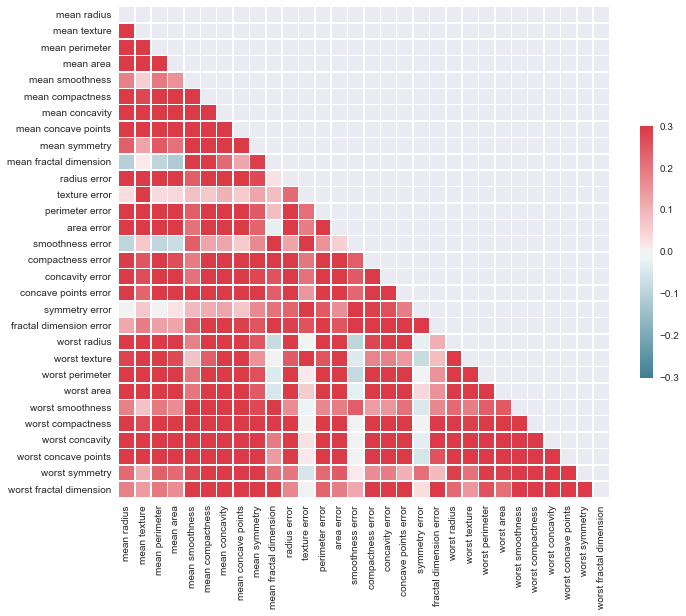

In [9]:
from skutil.h2o import h2o_corr_plot

# note that we want to exclude the target!!
h2o_corr_plot(X_train[x], xticklabels=x, yticklabels=x)

In [10]:
from skutil.h2o import H2OMulticollinearityFilterer

# Are we at risk of any multicollinearity?
mcf = H2OMulticollinearityFilterer(feature_names=x, target_feature=y, threshold=0.85)
mcf.fit(X_train)

# we can look at the dropped features
mcf.correlations_

[Dropped: mean perimeter, Corr_feature: mean radius, abs_corr: 0.98824, MAC: 0.44609,
 Dropped: mean radius, Corr_feature: mean area, abs_corr: 0.93647, MAC: 0.41866,
 Dropped: worst radius, Corr_feature: mean area, abs_corr: 0.87059, MAC: 0.41551,
 Dropped: worst perimeter, Corr_feature: mean area, abs_corr: 0.86118, MAC: 0.41611,
 Dropped: worst area, Corr_feature: mean area, abs_corr: 0.85176, MAC: 0.38551,
 Dropped: perimeter error, Corr_feature: radius error, abs_corr: 0.86118, MAC: 0.39706]

### Dropping features

As you'll see in the next section (Pipelines), where certain preprocessing steps take place matters. If there are a subset of features on which you don't want to model or process, you can drop them out. Sometimes this is more effective than creating a list of potentially thousands of feature names to pass as the `feature_names` parameter.

In [11]:
from skutil.h2o import H2OFeatureDropper

# maybe I don't like 'mean fractal dimension'
dropper = H2OFeatureDropper(feature_names=['mean fractal dimension'], target_feature=y)
transformed = dropper.fit_transform(X_train)

# we can ensure it's not there
assert not 'mean fractal dimension' in transformed.columns

### `skutil.h2o` modeling

Skutil's `h2o` module allows us to form the `Pipeline` objects we're familiar with from sklearn.  This permits us to string a series of preprocessors together, with an optional `H2OEstimator` as the last step.  Like sklearn `Pipeline`s, the first argument is a single list of length-two tuples (where the first arg is the name of the step, and the second is the Estimator/Transformer), however the `H2OPipeline` takes two more arguments: `feature_names` and `target_feature`.

__Note__ that the `feature_names` arg is the names the *first* preprocessor will operate on; after that, all remaining feature names (i.e., not the target) will be passed to the next processor.

In [12]:
from skutil.h2o import H2OPipeline
from h2o.estimators import H2OGradientBoostingEstimator
from skutil.h2o.metrics import h2o_accuracy_score # same as sklearn, but with H2OFrames

# let's fit a pipeline with our estimator...
pipe = H2OPipeline([
        ('hfd', H2OFeatureDropper()),
        ('nzv', H2ONearZeroVarianceFilterer(threshold=1e-4)),
        ('mcf', H2OMulticollinearityFilterer(threshold=0.85)),
        ('gbm', H2OGradientBoostingEstimator(ntrees=100, max_depth=5))
    ], 
    
    # feature_names is the set of features H2OFeatureDropper
    # will operate on. The remaining features will be passed
    # to the next step
    feature_names=['mean fractal dimension'], 
    target_feature=y)


# fit...
pipe = pipe.fit(X_train)


# eval accuracy on validation set
pred = pipe.predict(X_test)
actual = X_test[y]
pred = pred['predict']
print('Validation accuracy: %.5f' % h2o_accuracy_score(actual, pred))


gbm Model Build Progress: [##################################################] 100%

gbm prediction Progress: [##################################################] 100%
Validation accuracy: 0.90210


### Which features were retained?

We can see which features were modeled on with the `training_cols_` attribute of the fitted pipe.

In [16]:
pipe.training_cols_

['mean texture',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'radius error',
 'texture error',
 'area error',
 'compactness error',
 'concavity error',
 'worst texture',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

### Hyperparameter optimization

With relatively little effort, we got 90% accuracy on our validation set! Can we improve that? We can use `sklearn`-esque grid searches, which also allow us to search over preprocessor objects to optimize a set of hyperparameters.

In [14]:
from skutil.h2o import H2ORandomizedSearchCV
from skutil.h2o import H2OKFold
from scipy.stats import uniform, randint

# define our random state
rand_state = 42

# let's redefine our pipeline
pipe = H2OPipeline([
        ('hfd', H2OFeatureDropper()),
        ('nzv', H2ONearZeroVarianceFilterer()),
        ('mcf', H2OMulticollinearityFilterer()),
        ('gbm', H2OGradientBoostingEstimator(seed=rand_state))
    ])

# our hyperparameters over which to search...
hyper = {
    'nzv__threshold'    : uniform(1e-6,1e-2),
    'mcf__threshold'    : uniform(0.7, 0.29),
    'gbm__ntrees'       : randint(50, 100),
    'gbm__max_depth'    : randint(3, 10),
    'gbm__min_rows'     : randint(5, 50),
    'gbm__learn_rate'   : uniform(0.025, 0.075)
}

# define our grid search
search = H2ORandomizedSearchCV(
        estimator=pipe,
        param_grid=hyper,
        feature_names=['mean fractal dimension'], # passed to first estimator, the dropper
        target_feature=y,
        n_iter=5, # keep it small for our demo...
        random_state=rand_state,
        scoring='accuracy_score',
        cv=H2OKFold(n_folds=3, shuffle=True, random_state=rand_state),
        verbose=3
    )

# fit
search.fit(X_train)

[CV (iter 0, fold 0)] Target: target; gbm__min_rows=36, gbm__ntrees=74, mcf__threshold=0.836180520494, nzv__threshold=0.000155650772527, gbm__max_depth=5, gbm__learn_rate=0.0450666197133 

gbm Model Build Progress: [##################################################] 100%

gbm prediction Progress: [##################################################] 100%

[CV (iter 0, fold 0)]  Target: target; gbm__min_rows=36, gbm__ntrees=74, mcf__threshold=0.836180520494, nzv__threshold=0.000155650772527, gbm__max_depth=5, gbm__learn_rate=0.0450666197133, score=0.957746 -   4.4s


[CV (iter 0, fold 1)] Target: target; gbm__min_rows=36, gbm__ntrees=74, mcf__threshold=0.836180520494, nzv__threshold=0.000155650772527, gbm__max_depth=5, gbm__learn_rate=0.0450666197133 

gbm Model Build Progress: [##################################################] 100%

gbm prediction Progress: [##################################################] 100%

[CV (iter 0, fold 1)]  Target: target; gbm__min_rows=36, gbm__ntrees=

H2ORandomizedSearchCV(cv=H2OKFold(n_folds=3, random_state=42, shuffle=True),
           estimator=H2OPipeline(feature_names=None,
      steps=[('hfd', H2OFeatureDropper(feature_names=None, target_feature=None)), ('nzv', H2ONearZeroVarianceFilterer(feature_names=None, na_rm=False, na_warn=True,
              target_feature=None, threshold=1e-06, use='complete.obs')), ('mcf', H2OMulticollinearityFilterer(feature_names=None, na_rm=False, na_warn=True,
               target_feature=None, threshold=0.85, use='complete.obs')), ('gbm', )],
      target_feature=None),
           feature_names=['mean fractal dimension'], iid=True, n_iter=5,
           n_jobs=1,
           param_grid={'mcf__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x118e11bd0>, 'gbm__ntrees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x118e20710>, 'gbm__min_rows': <scipy.stats._distn_infrastructure.rv_frozen object at 0x118e209d0>, 'nzv__threshold': <scipy.stats....x118e20450>, 'gbm__learn_

### Model evaluation

Beyond merely observing our validation set score, we can dig into the cross validation scores of each model in our H2O grid search, and select the model that has not only the best mean score, but the model that minimizes variability in the CV scores.

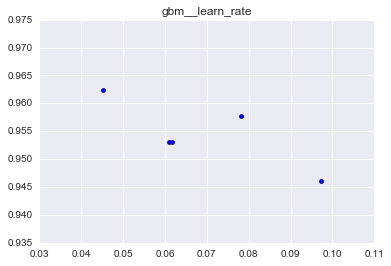

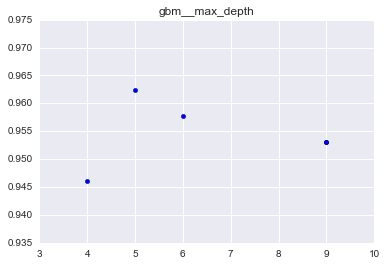

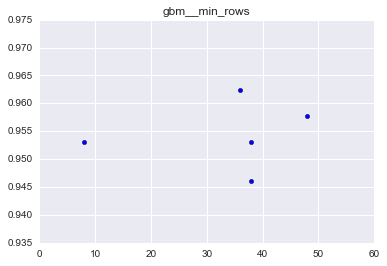

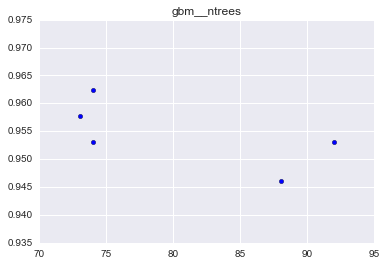

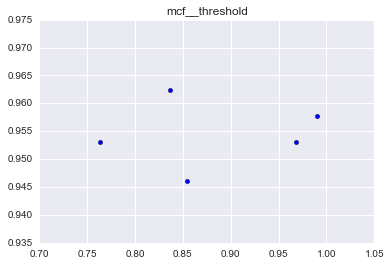

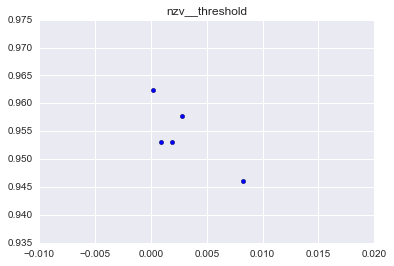

,gbm__learn_rate,gbm__max_depth,gbm__min_rows,gbm__ntrees,mcf__threshold,nzv__threshold,score,std
0,0.045067,5,36,74,0.836181,0.000156,0.962441,0.023460
1,0.078081,6,48,73,0.989851,0.002739,0.957746,0.029817
2,0.061007,9,8,74,0.967976,0.001916,0.953052,0.028362
3,0.061633,9,38,92,0.763197,0.000896,0.953052,0.006507
4,0.097387,4,38,88,0.853829,0.008209,0.946009,0.026026


In [17]:
from skutil.utils import report_grid_score_detail

# now let's look deeper...
report_grid_score_detail(search, charts=True, sort_results=True, ascending=False)

So our best estimator achieves a mean cross validation accuracy of 95%! We can predict on our best estimator as follows:

In [18]:
preds = search.predict(X_test)

# print accuracy
print('Validation accuracy: %.5f' % h2o_accuracy_score(actual, preds['predict']))

# look at head
preds.head()


gbm prediction Progress: [##################################################] 100%
Validation accuracy: 0.95804


predict,p0,p1
0,0.893059,0.106941
0,0.974544,0.0254558
0,0.977404,0.0225957
0,0.939651,0.0603489
0,0.638365,0.361635
0,0.958647,0.0413526
0,0.966105,0.0338949
0,0.977398,0.0226024
0,0.882556,0.117444
0,0.735658,0.264342


## Model persistence

When we find a model that performs well, we can save it to disk for later use:

In [19]:
import os

# get absolute path
cwd = os.getcwd()
model_path = os.path.join(cwd, 'grid.pkl')

# save -- it's that easy!!!
search.save(location=model_path)

### Loading and making predictions

In [20]:
the_model = H2ORandomizedSearchCV.load(model_path)
new_predictions = the_model.predict(X_test)
new_predictions.head()


gbm prediction Progress: [##################################################] 100%


predict,p0,p1
0,0.893059,0.106941
0,0.974544,0.0254558
0,0.977404,0.0225957
0,0.939651,0.0603489
0,0.638365,0.361635
0,0.958647,0.0413526
0,0.966105,0.0338949
0,0.977398,0.0226024
0,0.882556,0.117444
0,0.735658,0.264342


#### Cleanup

Always make sure to shut down your cluster...

In [21]:
h2o.shutdown(prompt=False) # shutdown cluster
os.unlink(model_path) # remove the pickle file...